### **Importing Libraries**

In [59]:
!pip install pytorch_tabnet torch_geometric optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.4 MB/s eta 0:00:00


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
import statsmodels.api as sm
from itertools import combinations
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

import torch
from pytorch_tabnet.tab_model import TabNetClassifier

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Preprocessing**

In [4]:
transactions = pd.read_csv("/content/drive/MyDrive/Capstone/Arial's/Fraud/transactions_data.csv")  # Transaction details
fraud_labels = pd.read_csv("/content/drive/MyDrive/Capstone/Arial's/Fraud/train_fraud_labels.csv")  # Fraud labels (Target variable is here which is Yes/No)
users = pd.read_csv("/content/drive/MyDrive/Capstone/Arial's/Fraud/users_data.csv")

# Merge on 'id' (transaction ID)
df = transactions.merge(fraud_labels, on="id", how="inner") #inner join since we dont need the blank values

# Merge users data
df = df.merge(users, left_on="client_id", right_on="id", how="left")  # Left join to keep all transactions
df.drop(columns=['id_y'], inplace=True)  # Drop the redundant user ID column
df.rename(columns={'id_x': 'id'}, inplace=True)  # Rename 'id_x' back to 'id'

In [5]:
# Preprocessing:

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])
df['transaction_hour'] = df['date'].dt.hour

# Convert 'amount' to numeric (removing '$' sign)
df['amount'] = df['amount'].replace('[$,]', '', regex=True).astype(float)

# Convert 'Target' to binary (Yes → 1, No → 0)
df['Target'] = df['Target'].str.strip().str.lower().map({'yes': 1, 'no': 0})

# Remove '$' and ',' from currency columns and convert to float
currency_columns = ['per_capita_income', 'yearly_income', 'total_debt']

for col in currency_columns:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Convert 'gender' to lowercase and strip spaces
df['gender'] = df['gender'].str.strip().str.lower()

# Convert 'use_chip' to categorical
df['use_chip'] = df['use_chip'].astype('category')

# Check unique values after standardization
print(df['gender'].unique())
print(df['use_chip'].unique())

['female' 'male']
['Swipe Transaction', 'Online Transaction', 'Chip Transaction']
Categories (3, object): ['Chip Transaction', 'Online Transaction', 'Swipe Transaction']


In [6]:
# Handling Missing Values:

# Drop the 'date' column since we no longer need it
# df.drop(columns=['date'], inplace=True)
# Drop 'errors' column (too many missing values)
df.drop(columns=['errors'], inplace=True)
# Fill missing merchant_state with "ONLINE" only when merchant_city is ONLINE. The way the dataset works: if merchant_city is 'ONLINE' then the merchant_state is blank, hence will append with merchant_state as ONLINE. My thought process: Fraud detection models may benefit from distinguishing between online & offline transactions.
df.loc[df['merchant_city'] == 'ONLINE', 'merchant_state'] = 'ONLINE'

# Imputing missing ZIP codes using merchant-based mode imputation.
# Logic: Since ZIP codes correspond to merchants (not users), I will fill missing values
# using the most frequent ZIP per `merchant_id`. If a merchant has no known ZIPs,
# I will use the most common ZIP in the dataset as a fallback.

# Fill missing ZIPs with the most frequent ZIP per merchant_id
df['zip'] = df.groupby('merchant_id')['zip'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
# Fill remaining missing ZIPs with the most frequent ZIP in the dataset
df['zip'].fillna(df['zip'].mode()[0], inplace=True)
# Convert ZIP to integer format
df['zip'] = df['zip'].astype(int)

<ipython-input-6-ab3ed18ba210>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['zip'].fillna(df['zip'].mode()[0], inplace=True)


In [7]:
# Winsorizing skewed variables (capping extreme values)
df['amount'] = winsorize(df['amount'], limits=[0, 0.01])  # Capping top 1%
df['total_debt'] = winsorize(df['total_debt'], limits=[0, 0.01])
df['yearly_income'] = winsorize(df['yearly_income'], limits=[0, 0.01])
df['per_capita_income'] = winsorize(df['per_capita_income'], limits=[0, 0.01])

In [8]:
# Log transformation for highly skewed features
df['amount'] = np.log1p(df['amount'].clip(lower=1))
df['total_debt'] = np.log1p(df['total_debt'].clip(lower=1))
df['yearly_income'] = np.log1p(df['yearly_income'].clip(lower=1))
df['per_capita_income'] = np.log1p(df['per_capita_income'].clip(lower=1))

In [9]:
top_states = df['merchant_state'].value_counts().nlargest(10).index  # Keep top 10
df['merchant_state'] = df['merchant_state'].apply(lambda x: x if x in top_states else "Other")
top_states

Index(['ONLINE', 'CA', 'TX', 'NY', 'FL', 'OH', 'IL', 'NC', 'PA', 'MI'], dtype='object', name='merchant_state')

In [10]:
# One-Hot Encoding for categorical features
df = pd.get_dummies(df, columns=['use_chip', 'merchant_state', 'gender'], dtype=int)

## **Feature Engineering**

In [11]:
## 1. Transaction-Based Feature: Amount Anomaly (Z-Score per User)

# Compute z-score for each user's transaction amount
df['amount_zscore'] = df.groupby('client_id')['amount'].transform(lambda x: zscore(x, nan_policy='omit'))

# Flag extreme outliers (e.g., >3 std deviations)
df['amount_anomaly'] = (df['amount_zscore'].abs() > 3).astype(int)


## 2. Merchant Consistency (Diversity per User)

# Count unique merchants per user
df['merchant_diversity'] = df.groupby('client_id')['merchant_id'].transform('nunique')

# Normalize by total transactions per user
df['merchant_diversity_ratio'] = df['merchant_diversity'] / df.groupby('client_id')['merchant_id'].transform('count')


## 3. High-Risk MCC Codes

# Group by MCC and calculate fraud rate
mcc_fraud_rate = df.groupby('mcc')['Target'].mean().reset_index()

# Sort by fraud rate
mcc_fraud_rate = mcc_fraud_rate.sort_values('Target', ascending=False)

# Select top MCC codes with highest fraud rates (e.g., top 5%)
high_risk_mccs = mcc_fraud_rate.head(int(len(mcc_fraud_rate) * 0.05))['mcc'].tolist()

# Group by MCC and calculate aggregated features (e.g., mean amount, transaction count, fraud count)
mcc_agg = df.groupby('mcc').agg(
    transaction_count=('Target', 'count'),
    fraud_count=('Target', 'sum'),
    avg_amount=('amount', 'mean')
).reset_index()

# Use Isolation Forest to detect MCC outliers
iso_forest = IsolationForest(contamination=0.05)  # 5% contamination (adjust as needed)
mcc_agg['outlier'] = iso_forest.fit_predict(mcc_agg[['transaction_count', 'fraud_count', 'avg_amount']])

# MCCs with outlier label (-1) are considered high-risk
high_risk_mccs.extend(mcc_agg[mcc_agg['outlier'] == -1]['mcc'].tolist())

# Combine both lists
high_risk_mccs_combined = list(set(high_risk_mccs))

# Add new high-risk indicator column based on combined high-risk MCCs
df['high_risk_mcc'] = df['mcc'].isin(high_risk_mccs_combined).astype(int)


In [12]:
df.head()

,id,date,client_id,card_id,amount,merchant_id,merchant_city,zip,mcc,Target,...,merchant_state_Other,merchant_state_PA,merchant_state_TX,gender_female,gender_male,amount_zscore,amount_anomaly,merchant_diversity,merchant_diversity_ratio,high_risk_mcc
0,7475327,2010-01-01 00:01:00,1556,2972,0.693147,59935,Beulah,58523,5499,0,...,1,0,0,1,0,-1.899856,0,205,0.059010,1
1,7475328,2010-01-01 00:02:00,561,4575,2.745346,67570,Bettendorf,52722,5311,0,...,1,0,0,0,1,-0.167103,0,358,0.045652,1
2,7475329,2010-01-01 00:02:00,1129,102,4.394449,27092,Vista,92084,4829,0,...,0,0,0,0,1,0.760677,0,254,0.026065,1
3,7475332,2010-01-01 00:06:00,848,3915,3.858833,13051,Harwood,20776,5813,0,...,1,0,0,0,1,-0.015300,0,323,0.072731,0
4,7475333,2010-01-01 00:07:00,1807,165,1.759581,20519,Bronx,10464,5942,0,...,0,0,0,1,0,-1.572432,0,409,0.030775,0


In [13]:
df.columns

Index(['id', 'date', 'client_id', 'card_id', 'amount', 'merchant_id',
       'merchant_city', 'zip', 'mcc', 'Target', 'current_age',
       'retirement_age', 'birth_year', 'birth_month', 'address', 'latitude',
       'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
       'credit_score', 'num_credit_cards', 'transaction_hour',
       'use_chip_Chip Transaction', 'use_chip_Online Transaction',
       'use_chip_Swipe Transaction', 'merchant_state_CA', 'merchant_state_FL',
       'merchant_state_IL', 'merchant_state_MI', 'merchant_state_NC',
       'merchant_state_NY', 'merchant_state_OH', 'merchant_state_ONLINE',
       'merchant_state_Other', 'merchant_state_PA', 'merchant_state_TX',
       'gender_female', 'gender_male', 'amount_zscore', 'amount_anomaly',
       'merchant_diversity', 'merchant_diversity_ratio', 'high_risk_mcc'],
      dtype='object')

In [ ]:
# Drop irrelevant cols
drop_cols = ['id', 'date', 'client_id', 'card_id', 'merchant_id', 'merchant_city', 'zip', 'mcc', 'address', 'latitude', 'longitude', 'Target']

# Define independent (X) and dependent (y) variables
X = df.drop(columns=drop_cols)  # Drop the target column
y = df['Target']  # Target variable

## **Handle Imbalanced Class**

In [53]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=42)  # Oversample fraud to 20%
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Balance to 1:2 ratio

# Create pipeline
imbalance_pipeline = Pipeline(steps=[("over", over), ("under", under)])

# Apply resampling
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

# Check the shape of the split
print("Train Set:", X_resampled.shape, y_resampled.shape)
print("Test Set:", X_test.shape, y_test.shape)

Train Set: (4272780, 32) (4272780,)
Test Set: (1782993, 32) (1782993,)


In [15]:
# # Split into training and testing sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Check the shape of the split
# print("Train Set:", X_train.shape, y_train.shape)
# print("Test Set:", X_test.shape, y_test.shape)

Train Set: (7131970, 32) (7131970,)
Test Set: (1782993, 32) (1782993,)


In [54]:
from sklearn.utils.class_weight import compute_class_weight

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_resampled),
    y=y_resampled
)
class_weight_dict = dict(zip(np.unique(y_resampled), class_weights))

print("Class weights: ", class_weight_dict)

Class weights:  {0: 0.75, 1: 1.5}


## **Modeling**

In [56]:
# Initialize and train TabNet model with class weights
tabnet_model = TabNetClassifier(
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax',
    verbose=1
)

try:
    tabnet_model.load_model('tabnet_fraud_model.zip')
except:
    tabnet_model.fit(
        # X_train.values, y_train.values,
        X_resampled.values, y_resampled.values,
        eval_set=[(X_test.values, y_test.values)],
        eval_metric=['auc'],
        max_epochs=10,
        patience=5,
        batch_size=1024,
        virtual_batch_size=128,
        weights=class_weight_dict,
        compute_importance=False
    )

    tabnet_model.save_model('tabnet_fraud_model')
    files.download("tabnet_fraud_model.zip")

# Evaluate on the test set
# y_pred_tabnet = tabnet_model.predict(X_test.values)


epoch 0  | loss: 0.2257  | val_0_auc: 0.92573 |  0:02:45s
epoch 1  | loss: 0.1888  | val_0_auc: 0.92888 |  0:05:31s
epoch 2  | loss: 0.17824 | val_0_auc: 0.93308 |  0:08:18s
epoch 3  | loss: 0.16696 | val_0_auc: 0.93455 |  0:11:05s
epoch 4  | loss: 0.16211 | val_0_auc: 0.93512 |  0:13:53s
epoch 5  | loss: 0.16194 | val_0_auc: 0.93596 |  0:16:39s
epoch 6  | loss: 0.1584  | val_0_auc: 0.9379  |  0:19:27s
epoch 7  | loss: 0.1602  | val_0_auc: 0.93576 |  0:22:12s
epoch 8  | loss: 0.15638 | val_0_auc: 0.93971 |  0:24:52s
epoch 9  | loss: 0.16054 | val_0_auc: 0.9251  |  0:27:33s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_auc = 0.93971
Successfully saved model at tabnet_fraud_model.zip


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       1.00      0.93      0.96   1780327
           1       0.02      0.81      0.03      2666

    accuracy                           0.93   1782993
   macro avg       0.51      0.87      0.50   1782993
weighted avg       1.00      0.93      0.96   1782993



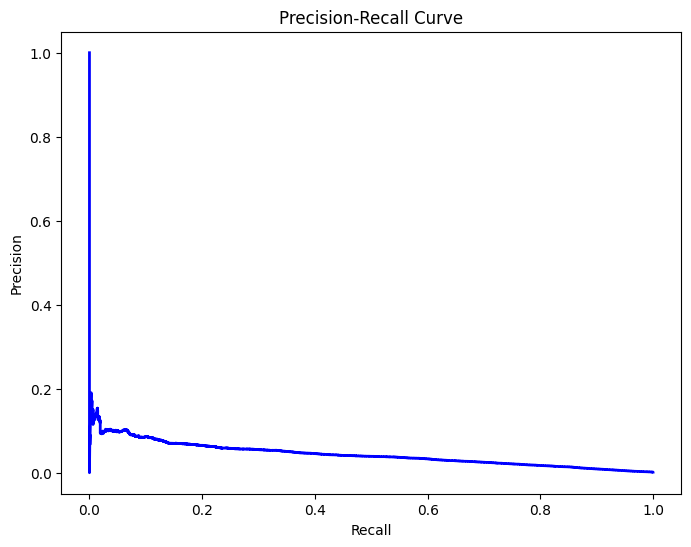

In [57]:
y_pred_proba = tabnet_model.predict_proba(X_test.values)[:, 1]
y_pred_tabnet = (y_pred_proba > 0.5).astype(int)
# Generate the classification report
print(classification_report(y_test.values, y_pred_tabnet))

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [61]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    n_d = trial.suggest_int("n_d", 8, 32, step=8)
    n_a = trial.suggest_int("n_a", 8, 32, step=8)
    n_steps = trial.suggest_int("n_steps", 3, 7)
    gamma = trial.suggest_float("gamma", 1.0, 2.0)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-5, 1e-3, log=True)
    lr = trial.suggest_float("lr", 1e-3, 2e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [512, 1024, 2048])

    tabnet_model = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type="sparsemax",
        verbose=1
    )

    tabnet_model.fit(
        X_resampled.values, y_resampled.values,
        eval_set=[(X_test.values, y_test.values)],
        eval_metric=["auc"],
        max_epochs=10,
        patience=3,
        batch_size=batch_size,
        virtual_batch_size=128,
        weights=class_weight_dict,
        compute_importance=False
    )

    # Evaluate PR-AUC
    y_pred_proba = tabnet_model.predict_proba(X_test.values)[:, 1]
    pr_auc = average_precision_score(y_test, y_pred_proba)

    return pr_auc

study = optuna.create_study(direction="maximize")  # Maximize PR-AUC
study.optimize(objective, n_trials=10)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2025-02-24 05:18:29,256] A new study created in memory with name: no-name-0581147a-98d9-4bc7-a78b-751ca4a2f7c4
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.25069 | val_0_auc: 0.91864 |  0:09:12s
epoch 1  | loss: 0.23114 | val_0_auc: 0.92463 |  0:18:38s
epoch 2  | loss: 0.19715 | val_0_auc: 0.93165 |  0:28:02s
epoch 3  | loss: 0.18191 | val_0_auc: 0.93478 |  0:37:25s
epoch 4  | loss: 0.16277 | val_0_auc: 0.93757 |  0:46:53s
epoch 5  | loss: 0.14766 | val_0_auc: 0.93971 |  0:56:21s
epoch 6  | loss: 0.14098 | val_0_auc: 0.9402  |  1:05:49s
epoch 7  | loss: 0.13513 | val_0_auc: 0.94085 |  1:15:14s
epoch 8  | loss: 0.13218 | val_0_auc: 0.93955 |  1:24:49s
epoch 9  | loss: 0.13016 | val_0_auc: 0.93818 |  1:34:25s
Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_0_auc = 0.94085


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-24 06:54:33,507] Trial 0 finished with value: 0.05399511685676662 and parameters: {'n_d': 8, 'n_a': 24, 'n_steps': 7, 'gamma': 1.2391396411912878, 'lambda_sparse': 0.00015333187457366258, 'lr': 0.015791702514464587, 'batch_size': 512}. Best is trial 0 with value: 0.05399511685676662.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.20093 | val_0_auc: 0.93368 |  0:03:32s
epoch 1  | loss: 0.13627 | val_0_auc: 0.94056 |  0:07:04s
epoch 2  | loss: 0.11853 | val_0_auc: 0.93972 |  0:10:37s
epoch 3  | loss: 0.1095  | val_0_auc: 0.93948 |  0:14:10s
epoch 4  | loss: 0.10375 | val_0_auc: 0.94227 |  0:17:41s
epoch 5  | loss: 0.11321 | val_0_auc: 0.93734 |  0:21:11s
epoch 6  | loss: 0.10705 | val_0_auc: 0.93987 |  0:24:42s
epoch 7  | loss: 0.09925 | val_0_auc: 0.93964 |  0:28:16s

Early stopping occurred at epoch 7 with best_epoch = 4 and best_val_0_auc = 0.94227


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-24 07:23:30,179] Trial 1 finished with value: 0.05781411798843815 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 3, 'gamma': 1.4042558841182553, 'lambda_sparse': 0.0001184352154046122, 'lr': 0.01161157454614417, 'batch_size': 1024}. Best is trial 1 with value: 0.05781411798843815.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.2469  | val_0_auc: 0.92696 |  0:07:21s
epoch 1  | loss: 0.17818 | val_0_auc: 0.93238 |  0:14:43s
epoch 2  | loss: 0.14336 | val_0_auc: 0.93743 |  0:22:07s
epoch 3  | loss: 0.12656 | val_0_auc: 0.93848 |  0:29:22s
epoch 4  | loss: 0.11635 | val_0_auc: 0.9394  |  0:36:37s
epoch 5  | loss: 0.11029 | val_0_auc: 0.94098 |  0:43:51s
epoch 6  | loss: 0.10609 | val_0_auc: 0.9391  |  0:51:05s
epoch 7  | loss: 0.10294 | val_0_auc: 0.94078 |  0:58:26s
epoch 8  | loss: 0.09969 | val_0_auc: 0.94241 |  1:05:42s
epoch 9  | loss: 0.09726 | val_0_auc: 0.94103 |  1:12:58s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_auc = 0.94241


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-24 08:37:44,073] Trial 2 finished with value: 0.07072799704451058 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.2013699325636715, 'lambda_sparse': 8.118013599776976e-05, 'lr': 0.0024769671852982234, 'batch_size': 512}. Best is trial 2 with value: 0.07072799704451058.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.20862 | val_0_auc: 0.92618 |  0:04:57s
epoch 1  | loss: 0.16349 | val_0_auc: 0.93182 |  0:09:54s
epoch 2  | loss: 0.15176 | val_0_auc: 0.93187 |  0:14:52s
epoch 3  | loss: 0.14495 | val_0_auc: 0.93191 |  0:19:50s
epoch 4  | loss: 0.13999 | val_0_auc: 0.93347 |  0:24:49s
epoch 5  | loss: 0.13756 | val_0_auc: 0.93151 |  0:29:46s
epoch 6  | loss: 0.13548 | val_0_auc: 0.93494 |  0:34:45s
epoch 7  | loss: 0.1343  | val_0_auc: 0.93364 |  0:39:44s
epoch 8  | loss: 0.13297 | val_0_auc: 0.93333 |  0:44:43s
epoch 9  | loss: 0.13196 | val_0_auc: 0.93478 |  0:49:43s

Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_0_auc = 0.93494


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-24 09:28:20,492] Trial 3 finished with value: 0.044582153302306526 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.803380970760287, 'lambda_sparse': 3.0969797272189e-05, 'lr': 0.01698971966572, 'batch_size': 512}. Best is trial 2 with value: 0.07072799704451058.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.32408 | val_0_auc: 0.91165 |  0:03:56s
epoch 1  | loss: 0.22759 | val_0_auc: 0.91896 |  0:07:51s
epoch 2  | loss: 0.21504 | val_0_auc: 0.91764 |  0:11:47s
epoch 3  | loss: 0.20914 | val_0_auc: 0.9243  |  0:15:47s
epoch 4  | loss: 0.19512 | val_0_auc: 0.92379 |  0:19:54s
epoch 5  | loss: 0.18538 | val_0_auc: 0.92639 |  0:23:59s
epoch 6  | loss: 0.17351 | val_0_auc: 0.92842 |  0:28:06s
epoch 7  | loss: 0.16033 | val_0_auc: 0.93001 |  0:32:13s
epoch 8  | loss: 0.15183 | val_0_auc: 0.93008 |  0:36:21s
epoch 9  | loss: 0.14842 | val_0_auc: 0.92967 |  0:40:23s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_auc = 0.93008


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-24 10:09:29,134] Trial 4 finished with value: 0.04379727420300495 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.7730671585709485, 'lambda_sparse': 0.000367941884570388, 'lr': 0.003218942407696001, 'batch_size': 2048}. Best is trial 2 with value: 0.07072799704451058.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.2387  | val_0_auc: 0.92588 |  0:06:09s
epoch 1  | loss: 0.1778  | val_0_auc: 0.93269 |  0:12:17s
epoch 2  | loss: 0.15367 | val_0_auc: 0.93721 |  0:18:25s
epoch 3  | loss: 0.14059 | val_0_auc: 0.93737 |  0:24:38s
epoch 4  | loss: 0.13151 | val_0_auc: 0.93947 |  0:30:47s
epoch 5  | loss: 0.12506 | val_0_auc: 0.942   |  0:36:57s
epoch 6  | loss: 0.12064 | val_0_auc: 0.94081 |  0:43:07s
epoch 7  | loss: 0.11735 | val_0_auc: 0.94395 |  0:49:18s
epoch 8  | loss: 0.11411 | val_0_auc: 0.94211 |  0:55:30s
epoch 9  | loss: 0.11154 | val_0_auc: 0.94249 |  1:01:41s
Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_0_auc = 0.94395


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-24 11:12:15,852] Trial 5 finished with value: 0.06735283240001746 and parameters: {'n_d': 24, 'n_a': 8, 'n_steps': 4, 'gamma': 1.1474202852784408, 'lambda_sparse': 3.356404160145193e-05, 'lr': 0.0016313316839177536, 'batch_size': 512}. Best is trial 2 with value: 0.07072799704451058.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.27956 | val_0_auc: 0.91978 |  0:07:17s
epoch 1  | loss: 0.20541 | val_0_auc: 0.92404 |  0:14:34s
epoch 2  | loss: 0.17734 | val_0_auc: 0.93143 |  0:21:52s
epoch 3  | loss: 0.15928 | val_0_auc: 0.93109 |  0:29:15s
epoch 4  | loss: 0.14226 | val_0_auc: 0.93626 |  0:36:38s
epoch 5  | loss: 0.1295  | val_0_auc: 0.93499 |  0:43:57s
epoch 6  | loss: 0.12021 | val_0_auc: 0.93544 |  0:51:09s
epoch 7  | loss: 0.11397 | val_0_auc: 0.93566 |  0:58:27s

Early stopping occurred at epoch 7 with best_epoch = 4 and best_val_0_auc = 0.93626


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-24 12:11:59,594] Trial 6 finished with value: 0.046375846808125884 and parameters: {'n_d': 32, 'n_a': 24, 'n_steps': 5, 'gamma': 1.7489427756439362, 'lambda_sparse': 2.2548385549015367e-05, 'lr': 0.0014424778331380774, 'batch_size': 512}. Best is trial 2 with value: 0.07072799704451058.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.29867 | val_0_auc: 0.91165 |  0:05:07s
epoch 1  | loss: 0.22572 | val_0_auc: 0.91884 |  0:10:13s
epoch 2  | loss: 0.20688 | val_0_auc: 0.9266  |  0:15:17s
epoch 3  | loss: 0.18586 | val_0_auc: 0.92903 |  0:20:20s
epoch 4  | loss: 0.1554  | val_0_auc: 0.93197 |  0:25:27s
epoch 5  | loss: 0.1379  | val_0_auc: 0.93325 |  0:30:34s
epoch 6  | loss: 0.13769 | val_0_auc: 0.93332 |  0:35:41s
epoch 7  | loss: 0.12014 | val_0_auc: 0.93661 |  0:40:46s
epoch 8  | loss: 0.11423 | val_0_auc: 0.93597 |  0:45:52s
epoch 9  | loss: 0.10345 | val_0_auc: 0.9378  |  0:50:58s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_auc = 0.9378


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-24 13:03:54,521] Trial 7 finished with value: 0.059396630629635384 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 7, 'gamma': 1.4566631758962956, 'lambda_sparse': 5.929492365707746e-05, 'lr': 0.0069954530029085775, 'batch_size': 2048}. Best is trial 2 with value: 0.07072799704451058.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.30008 | val_0_auc: 0.9132  |  0:05:06s
epoch 1  | loss: 0.22724 | val_0_auc: 0.92325 |  0:10:20s
epoch 2  | loss: 0.21045 | val_0_auc: 0.92244 |  0:15:30s
epoch 3  | loss: 0.18112 | val_0_auc: 0.93561 |  0:20:39s
epoch 4  | loss: 0.16321 | val_0_auc: 0.93662 |  0:25:44s
epoch 5  | loss: 0.13505 | val_0_auc: 0.93843 |  0:30:52s
epoch 6  | loss: 0.12664 | val_0_auc: 0.93901 |  0:35:59s
epoch 7  | loss: 0.11542 | val_0_auc: 0.93804 |  0:41:05s
epoch 8  | loss: 0.10948 | val_0_auc: 0.93613 |  0:46:11s
epoch 9  | loss: 0.10253 | val_0_auc: 0.93879 |  0:51:18s

Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_0_auc = 0.93901


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-24 13:56:09,082] Trial 8 finished with value: 0.049254092407554795 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 7, 'gamma': 1.331090837422415, 'lambda_sparse': 8.453824312488373e-05, 'lr': 0.007044047901296326, 'batch_size': 2048}. Best is trial 2 with value: 0.07072799704451058.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.23001 | val_0_auc: 0.92036 |  0:05:03s
epoch 1  | loss: 0.16418 | val_0_auc: 0.93109 |  0:10:06s
epoch 2  | loss: 0.13564 | val_0_auc: 0.94324 |  0:15:09s
epoch 3  | loss: 0.11943 | val_0_auc: 0.94217 |  0:20:12s
epoch 4  | loss: 0.11141 | val_0_auc: 0.94317 |  0:25:13s
epoch 5  | loss: 0.10553 | val_0_auc: 0.94317 |  0:30:15s

Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.94324


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-02-24 14:27:19,921] Trial 9 finished with value: 0.04890707013515104 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 5, 'gamma': 1.152718416359144, 'lambda_sparse': 4.457412540320173e-05, 'lr': 0.011783345415092319, 'batch_size': 1024}. Best is trial 2 with value: 0.07072799704451058.


Best hyperparameters: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.2013699325636715, 'lambda_sparse': 8.118013599776976e-05, 'lr': 0.0024769671852982234, 'batch_size': 512}


In [62]:
best_params = study.best_params  # Get the best hyperparameters

# Train TabNet with the best hyperparameters
best_tabnet_model = TabNetClassifier(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params["lr"]),
    mask_type="sparsemax",
    verbose=1
)

best_tabnet_model.fit(
    X_resampled.values, y_resampled.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_metric=["auc"],
    max_epochs=10,
    patience=3,
    batch_size=best_params["batch_size"],
    virtual_batch_size=128,
    weights=class_weight_dict,
    compute_importance=False
)

# Save the best model
best_tabnet_model.save_model("best_tabnet_model")
files.download("best_tabnet_model.zip")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.2469  | val_0_auc: 0.92696 |  0:07:14s
epoch 1  | loss: 0.17818 | val_0_auc: 0.93238 |  0:14:28s
epoch 2  | loss: 0.14336 | val_0_auc: 0.93743 |  0:21:43s
epoch 3  | loss: 0.12656 | val_0_auc: 0.93848 |  0:28:55s
epoch 4  | loss: 0.11635 | val_0_auc: 0.9394  |  0:36:09s
epoch 5  | loss: 0.11029 | val_0_auc: 0.94098 |  0:43:22s
epoch 6  | loss: 0.10609 | val_0_auc: 0.9391  |  0:50:33s
epoch 7  | loss: 0.10294 | val_0_auc: 0.94078 |  0:57:45s
epoch 8  | loss: 0.09969 | val_0_auc: 0.94241 |  1:04:57s
epoch 9  | loss: 0.09726 | val_0_auc: 0.94103 |  1:12:12s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_auc = 0.94241
Successfully saved model at best_tabnet_model.zip.zip


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


FileNotFoundError: Cannot find file: best_tabnet_model.zip

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1780327
           1       0.03      0.76      0.05      2666

    accuracy                           0.96   1782993
   macro avg       0.51      0.86      0.51   1782993
weighted avg       1.00      0.96      0.98   1782993



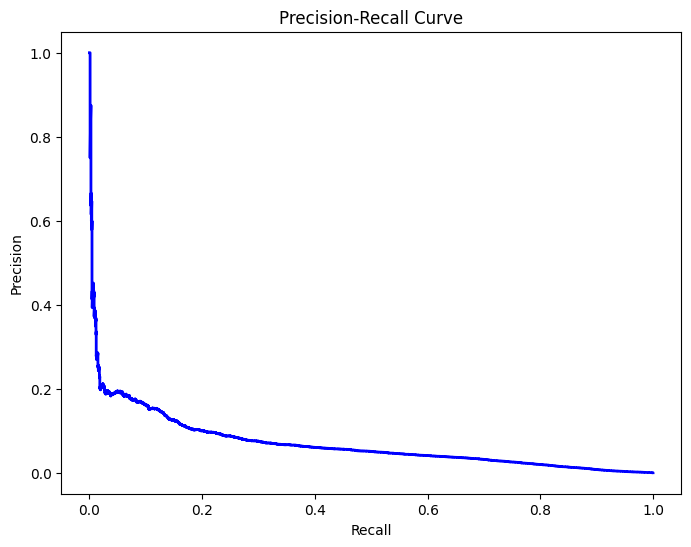

In [75]:
# Use the trained model for predictions
y_pred_proba = best_tabnet_model.predict_proba(X_test.values)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Generate the classification report
print(classification_report(y_test.values, y_pred))

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## **Test Loading**

In [ ]:
test_model = TabNetClassifier()
test_model.load_model("best_tabnet_model.zip")

test = test_model.predict(X_test.values)
print(classification_report(y_test.values, test))